In [1]:
!nvidia-smi

Thu Jun 27 16:32:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   69C    P0              33W /  72W |   3088MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### 0. 라이브러리

In [2]:
# 라이브러리
import warnings
warnings.filterwarnings('ignore')

import os
import time
import pickle
import random
import zipfile
import copy
import glob
import shutil

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score

import transformers
from transformers import AutoTokenizer, AutoModel, AutoConfig, get_linear_schedule_with_warmup

In [3]:
# 시드 고정
def fixSEED(seed, deterministic=True):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    transformers.set_seed(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

SEED = 42
fixSEED(seed=SEED)

In [4]:
# 디렉토리 설정
dir = 'Python_Programs'
path = '/home/leesanghyuk2000/' + dir
os.chdir(path)
print('Current path {}'.format(os.getcwd()))

Current path /home/leesanghyuk2000/Python_Programs


In [5]:
# GPU 사용 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
def checkGPU(empty=False):
    if torch.cuda.is_available():
        total_mem = torch.cuda.get_device_properties(0).total_memory
        current_mem = torch.cuda.memory_allocated(0)
        free_mem = total_mem - current_mem
        
        print(f'남은 GPU 메모리: {free_mem / (1024 ** 3):.2f} GB')
        
        if empty:
            torch.cuda.empty_cache()
            after_mem = torch.cuda.memory_allocated(0)
            print(f'GPU 캐시에서 메모리 삭제 후 메모리: {after_mem / (1024 ** 3):.2f} GB')
    else:
        print('CUDA 사용 불가')
        
checkGPU()

남은 GPU 메모리: 21.96 GB


### 1. 데이터 불러오기

In [7]:
# Load data from a pickle file, and create labels
def callData(path: str):
    with open(path, "rb") as file:
        data = pickle.load(file)

    zero = data[data['label']==0]
    non_zero = data[data['label']==1]

    print(f'레이블 0 개수 : {len(zero)}')
    print(f'레이블 1 개수 : {len(non_zero)}')

    return data

In [8]:
aihub_data = callData('AiHub_Sampled(2000).pkl')

레이블 0 개수 : 990
레이블 1 개수 : 992


In [9]:
youtube_data = callData('youtubeData(8331)_with_label.pkl')

레이블 0 개수 : 5208
레이블 1 개수 : 3123


In [10]:
# concat two data
text1 = aihub_data['newsContent'] # 제목 미포함
text2 = youtube_data['content'] # 제목 미포함

label1 = aihub_data['label']
label2 = youtube_data['label']

data = pd.DataFrame({
    'text': pd.concat([text1, text2], ignore_index=True),
    'label': pd.concat([label1, label2], ignore_index=True)
})

In [12]:
# 레이블 확인
data['label'].value_counts()

label
0    6198
1    4115
Name: count, dtype: int64

### 2. Train/Test/Valid

In [13]:
# Split into Train/Valid/Test
def splitData(data, SEED=42):
    train_val_data, test_data = train_test_split(data, test_size=0.2, random_state=SEED, stratify=data['label'])
    train_data, valid_data = train_test_split(train_val_data, test_size=0.25, random_state=SEED, stratify=train_val_data['label'])

    print('학습용 데이터 개수 : {}개 \n검증용 데이터 개수 : {}개 \n평가용 데이터 개수 : {}개'.format(len(train_data), len(valid_data), len(test_data)))
    del train_val_data
    return train_data, valid_data, test_data

In [14]:
train_data, valid_data, test_data = splitData(data)

학습용 데이터 개수 : 6187개 
검증용 데이터 개수 : 2063개 
평가용 데이터 개수 : 2063개


### 3. Dataset 및 Dataloader 정의

In [15]:
# 파라미터 개수 확인
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"Trainable Params: {trainable_params} \nAll params: {all_param}")
    print('-'*50)
    print(f"Trainable(%): {round(100 * trainable_params / all_param, 5)}")

In [37]:
# Mixed Dataset for Transformers
class TransformersDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        label = self.data.iloc[idx]['label']
        
        inputs = self.tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)
        
        input_ids = inputs['input_ids'].squeeze(0)
        attention_mask = inputs['attention_mask'].squeeze(0)

        return input_ids, attention_mask, torch.tensor(label, dtype=torch.long) # 정수형

### 4. 모델 정의

#### 4-1. Transformers Encoder

In [17]:
# Scaled Dot-Product Attention
def scaled_dot_product_attention(query, key, value):
    dim_k = query.size(-1)
    scores = torch.bmm(query, key.transpose(1, 2)) / sqrt(dim_k)
    weights = F.softmax(scores, dim=-1)
    return torch.bmm(weights, value)

# Attention Head
class AttentionHead(nn.Module):
    def __init__(self, embed_dim, head_dim):
        super().__init__()
        self.q = nn.Linear(embed_dim, head_dim)
        self.k = nn.Linear(embed_dim, head_dim)
        self.v = nn.Linear(embed_dim, head_dim)

    def forward(self, hidden_state):
        attn_outputs = scaled_dot_product_attention(
            self.q(hidden_state), self.k(hidden_state), self.v(hidden_state))
        return attn_outputs
    
# Multi-Head Attention
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        embed_dim = config.hidden_size
        num_heads = config.num_attention_heads
        head_dim = embed_dim // num_heads
        self.heads = nn.ModuleList(
            [AttentionHead(embed_dim, head_dim) for _ in range(num_heads)]
        )
        self.output_linear = nn.Linear(embed_dim, embed_dim)

    def forward(self, hidden_state):
        x = torch.cat([h(hidden_state) for h in self.heads], dim=-1)
        x = self.output_linear(x)
        return x

# Feed Forward Network
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.linear_1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.linear_2 = nn.Linear(config.intermediate_size, config.hidden_size)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, x):
        x = self.linear_1(x)
        x = self.gelu(x)
        x = self.linear_2(x)
        x = self.dropout(x)
        return x
    
# Embeddings
class Embeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_embeddings = nn.Embedding(config.vocab_size, config.hidden_size)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.layer_norm = nn.LayerNorm(config.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, input_ids):
        # 입력 시퀀스에 대해 위치 ID를 만듭니다.
        seq_length = input_ids.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device).unsqueeze(0)
        # 토큰 임베딩과 위치 임베딩을 만듭니다.
        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        # 토큰 임베딩과 위치 임베딩을 합칩니다.
        embeddings = token_embeddings + position_embeddings
        embeddings = self.layer_norm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

# Transformer Encoder Layer
class TransformerEncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(config.hidden_size)
        self.layer_norm_2 = nn.LayerNorm(config.hidden_size)
        self.attention = MultiHeadAttention(config)
        self.feed_forward = FeedForward(config)

    def forward(self, x):
        # 층 정규화를 적용하고 입력을 쿼리, 키, 값으로 복사합니다.
        hidden_state = self.layer_norm_1(x)
        # 어텐션에 스킵 연결을 적용합니다.
        x = x + self.attention(hidden_state)
        # 스킵 연결과 피드 포워드 층을 적용합니다.
        x = x + self.feed_forward(self.layer_norm_2(x))
        return x
    
# Transformer Encoder
class TransformerEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embeddings = Embeddings(config)
        self.layers = nn.ModuleList([TransformerEncoderLayer(config)
                                     for _ in range(config.num_hidden_layers)])

    def forward(self, x):
        x = self.embeddings(x)
        for layer in self.layers:
            x = layer(x)
        return x

#### 4-2. Attention Mechanism

In [18]:
# Attention Mechanism
class AttentionMechanism(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AttentionMechanism, self).__init__()
        self.attention = nn.Linear(input_dim, hidden_dim)
        self.context_vector = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, features):
        # features: (batch_size, seq_len, input_dim)
        attention_weights = torch.tanh(self.attention(features))
        attention_weights = self.context_vector(attention_weights).squeeze(-1)
        attention_weights = F.softmax(attention_weights, dim=1)
        context_vector = torch.sum(features * attention_weights.unsqueeze(-1), dim=1)
        return context_vector, attention_weights

#### 4-3. Transformers Models

In [53]:
class TransformerModel(nn.Module):
    def __init__(self, text_config):
        super(TransformerModel, self).__init__()

        # Use Transformer Encoder for text
        self.text_model = TransformerEncoder(text_config)

        # Attention Mechanism
        self.attention = AttentionMechanism(text_config.hidden_size, 512)

        # Classifier layer
        self.classifier = nn.Linear(text_config.hidden_size, 2)

        # Dropout
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_ids, attention_mask):
        # Text model forward
        text_hidden_state = self.text_model(input_ids)

        # Apply attention mechanism
        context_vector, attention_weights = self.attention(text_hidden_state.unsqueeze(1))

        # Apply dropout
        context_vector = self.dropout(context_vector)

        # Pass through classifier
        logits = self.classifier(context_vector[:, -1, :]) # 출력 크기 변경 : [batch_size, seq_length, num_classes]->[batch_size, num_classes]

        return logits

### 5. 학습용 Trainer 정의

In [54]:
class Trainer:
    def __init__(self, model, train_dataloader, valid_dataloader, criterion, optimizer, acc_metric, precision_metric, recall_metric, f1_metric, device, num_epochs, wait_for_es):
        self.model = model  # model for training
        self.train_dataloader = train_dataloader  # training dataloader
        self.valid_dataloader = valid_dataloader  # validation dataloader
        self.criterion = criterion  # loss function
        self.optimizer = optimizer  # optimizer
        self.acc_metric = acc_metric  # accuracy metric
        self.precision_metric = precision_metric  # precision metric
        self.recall_metric = recall_metric  # recall metric
        self.f1_metric = f1_metric  # f1 score metric
        self.device = device  # device(cuda or cpu)
        self.num_epochs = num_epochs  # number of epochs
        self.wait_for_es = wait_for_es  # early stopping patience

        # 스케줄러 초기화
        total_steps = len(train_dataloader) * num_epochs
        self.scheduler = get_linear_schedule_with_warmup(self.optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    def train(self):
        train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history = [], [], [], [], []
        valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history = [], [], [], [], []

        best_loss = float('inf')
        count = 0
        best_acc = 0
        start_time = time.time()

        for epoch in range(self.num_epochs):
            print('-' * 120)
            print(f'Epoch {epoch+1}/{self.num_epochs}')
            print('-' * 120)

            train_loss, train_acc, train_precision, train_recall, train_f1 = self._train_model()
            valid_loss, valid_acc, valid_precision, valid_recall, valid_f1 = self._valid_model()

            train_loss_history.append(train_loss)
            train_acc_history.append(train_acc)
            train_precision_history.append(train_precision)
            train_recall_history.append(train_recall)
            train_f1_history.append(train_f1)

            valid_loss_history.append(valid_loss)
            valid_acc_history.append(valid_acc)
            valid_precision_history.append(valid_precision)
            valid_recall_history.append(valid_recall)
            valid_f1_history.append(valid_f1)

            elapsed_time = time.time() - start_time
            print(f'[Train] \t Loss: {train_loss:.4f} \t Acc: {train_acc:.4f} \t Precision: {train_precision:.4f} \t Recall: {train_recall:.4f} \t F1: {train_f1:.4f}')
            print(f'[Valid] \t Loss: {valid_loss:.4f} \t Acc: {valid_acc:.4f} \t Precision: {valid_precision:.4f} \t Recall: {valid_recall:.4f} \t F1: {valid_f1:.4f}')
            print(f'▶️ Epoch {epoch+1} complete in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s')

            if valid_acc > best_acc:
                best_acc = valid_acc
                try:
                    save_path = f'./YouTube(mixed)_Transformers_ACC_{valid_acc:.4f}.pth'
                    torch.save(self.model.state_dict(), save_path)
                    print(f'▶️ Model Saved to {save_path}')
                except Exception as e:
                    print(f'▶️ Model Not Saved: {e}')
                    continue

            if valid_loss < best_loss:
                best_loss = valid_loss
                count = 0
            else:
                count += 1
                if count >= self.wait_for_es:
                    print(f'▶️▶️▶️ Early Stopping at Epoch {epoch+1} ◀️◀️◀️')
                    break

        return train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history, valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history

    # Training function
    def _train_model(self):
        self.model.train()

        train_loss = 0
        train_acc = 0
        train_precision = 0
        train_recall = 0
        train_f1 = 0

        for batch in tqdm(self.train_dataloader, desc='Training'):
            input_ids, attention_mask, y = batch
            input_ids, attention_mask, y = input_ids.to(self.device), attention_mask.to(self.device), y.to(self.device)

            outputs = self.model(input_ids, attention_mask)
            #print(f"outputs shape: {outputs.shape}, y shape: {y.shape}")
            loss = self.criterion(outputs, y)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()  # 스케줄러 업데이트

            preds = torch.argmax(outputs, dim=1)
            train_loss += loss.item()
            train_acc += self.acc_metric(preds, y).item()
            train_precision += self.precision_metric(preds, y).item()
            train_recall += self.recall_metric(preds, y).item()
            train_f1 += self.f1_metric(preds, y).item()

        return train_loss / len(self.train_dataloader), train_acc / len(self.train_dataloader), train_precision / len(self.train_dataloader), train_recall / len(self.train_dataloader), train_f1 / len(self.train_dataloader)

    # Validating function
    def _valid_model(self):
        self.model.eval()

        valid_loss = 0
        valid_acc = 0
        valid_precision = 0
        valid_recall = 0
        valid_f1 = 0

        with torch.no_grad():
            for batch in tqdm(self.valid_dataloader, desc='Validating'):
                input_ids, attention_mask, y = batch
                input_ids, attention_mask, y = input_ids.to(self.device), attention_mask.to(self.device), y.to(self.device)

                outputs = self.model(input_ids, attention_mask)
                loss = self.criterion(outputs, y)

                preds = torch.argmax(outputs, dim=1)
                valid_loss += loss.item()
                valid_acc += self.acc_metric(preds, y).item()
                valid_precision += self.precision_metric(preds, y).item()
                valid_recall += self.recall_metric(preds, y).item()
                valid_f1 += self.f1_metric(preds, y).item()

        return valid_loss / len(self.valid_dataloader), valid_acc / len(self.valid_dataloader), valid_precision / len(self.valid_dataloader), valid_recall / len(self.valid_dataloader), valid_f1 / len(self.valid_dataloader)

### 6. 학습 진행

In [55]:
# 데이터셋 파라미터
batch_size = 32
num_labels = 2
max_length = 128

# text 토크나이저 정의
text_checkpoint = "klue/roberta-small"
tokenizer = AutoTokenizer.from_pretrained(text_checkpoint)

In [56]:
# 데이터셋 정의
train_dataset = TransformersDataset(train_data, tokenizer, max_length)
valid_dataset = TransformersDataset(valid_data, tokenizer, max_length)
test_dataset = TransformersDataset(test_data, tokenizer, max_length)

In [57]:
# 데이터로더 정의
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

next(iter(train_dataloader))

[tensor([[    0,  7024,  2151,  ...,  1513,  2359,     2],
         [    0,  4224,  3699,  ...,  4883,   555,     2],
         [    0,   752,  3753,  ...,  2047,  2069,     2],
         ...,
         [    0,  4528,  7186,  ...,  2470,  4103,     2],
         [    0,  5891,  2205,  ...,  2633,  2085,     2],
         [    0,   752, 22442,  ...,  6233,  7185,     2]]),
 tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]),
 tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0])]

In [58]:
# Model
text_config = AutoConfig.from_pretrained(text_checkpoint)

model = TransformerModel(text_config)
model.to(device)

TransformerModel(
  (text_model): TransformerEncoder(
    (embeddings): Embeddings(
      (token_embeddings): Embedding(32000, 768)
      (position_embeddings): Embedding(514, 768)
      (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (layer_norm_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (layer_norm_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attention): MultiHeadAttention(
          (heads): ModuleList(
            (0-11): 12 x AttentionHead(
              (q): Linear(in_features=768, out_features=64, bias=True)
              (k): Linear(in_features=768, out_features=64, bias=True)
              (v): Linear(in_features=768, out_features=64, bias=True)
            )
          )
          (output_linear): Linear(in_features=768, out_features=768, bias=True)
        )
        (feed_forward): Fee

In [59]:
print_trainable_parameters(model)

Trainable Params: 67895298 
All params: 67895298
--------------------------------------------------
Trainable(%): 100.0


In [60]:
# 학습 파라미터
num_epochs = 3
wait_for_es = 5

learning_rate = 2e-5
wd_rate = 3e-3
eps_rate = 1e-8

In [61]:
# 손실함수, 옵티마이저, Metrics
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=wd_rate, eps=eps_rate)
acc_metric = BinaryAccuracy().to(device)
f1_metric = BinaryF1Score().to(device)
precision_metric = BinaryPrecision().to(device)
recall_metric = BinaryRecall().to(device)

In [62]:
# Trainer 정의
trainer = Trainer(model,
                  train_dataloader,
                  valid_dataloader,
                  criterion,
                  optimizer,
                  acc_metric,
                  precision_metric,
                  recall_metric,
                  f1_metric,
                  device,
                  num_epochs,
                  wait_for_es)

In [63]:
# 학습 시작
train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history, valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history = trainer.train()

------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch 1/3
------------------------------------------------------------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:13<00:00,  4.74it/s]


[Train] 	 Loss: 0.5694 	 Acc: 0.7009 	 Precision: 0.6426 	 Recall: 0.5555 	 F1: 0.5484
[Valid] 	 Loss: 0.5049 	 Acc: 0.7488 	 Precision: 0.6278 	 Recall: 0.8977 	 F1: 0.7316
▶️ Epoch 1 complete in 1m 17s
▶️ Model Saved to ./YouTube(mixed)_Transformers_ACC_0.7488.pth
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch 2/3
------------------------------------------------------------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:13<00:00,  4.65it/s]


[Train] 	 Loss: 0.4222 	 Acc: 0.7945 	 Precision: 0.7695 	 Recall: 0.7246 	 F1: 0.7230
[Valid] 	 Loss: 0.4147 	 Acc: 0.7936 	 Precision: 0.7285 	 Recall: 0.7796 	 F1: 0.7456
▶️ Epoch 2 complete in 2m 35s
▶️ Model Saved to ./YouTube(mixed)_Transformers_ACC_0.7936.pth
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch 3/3
------------------------------------------------------------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:13<00:00,  4.76it/s]


[Train] 	 Loss: 0.3709 	 Acc: 0.8206 	 Precision: 0.7846 	 Recall: 0.7696 	 F1: 0.7678
[Valid] 	 Loss: 0.4089 	 Acc: 0.7945 	 Precision: 0.7266 	 Recall: 0.7812 	 F1: 0.7456
▶️ Epoch 3 complete in 3m 53s
▶️ Model Saved to ./YouTube(mixed)_Transformers_ACC_0.7945.pth


In [64]:
# 학습 과정 시각화 함수
def plot_training_history(train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history,
                          valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history):
    plt.figure(figsize=(16, 9))

    # Loss Plot
    ax1 = plt.subplot2grid((2, 4), (0, 0), colspan=4)
    ax1.plot(train_loss_history, label='Train Loss')
    ax1.plot(valid_loss_history, label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Accuracy Plot
    ax2 = plt.subplot2grid((2, 4), (1, 0))
    ax2.plot(train_acc_history, label='Train Accuracy')
    ax2.plot(valid_acc_history, label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    # Precision Plot
    ax3 = plt.subplot2grid((2, 4), (1, 1))
    ax3.plot(train_precision_history, label='Train Precision')
    ax3.plot(valid_precision_history, label='Validation Precision')
    ax3.set_title('Training and Validation Precision')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Precision')
    ax3.legend()

    # Recall Plot
    ax4 = plt.subplot2grid((2, 4), (1, 2))
    ax4.plot(train_recall_history, label='Train Recall')
    ax4.plot(valid_recall_history, label='Validation Recall')
    ax4.set_title('Training and Validation Recall')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Recall')
    ax4.legend()

    # F1 Plot
    ax5 = plt.subplot2grid((2, 4), (1, 3))
    ax5.plot(train_f1_history, label='Train F1 Score')
    ax5.plot(valid_f1_history, label='Validation F1 Score')
    ax5.set_title('Training and Validation F1 Score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 Score')
    ax5.legend()

    plt.tight_layout()
    plt.show()

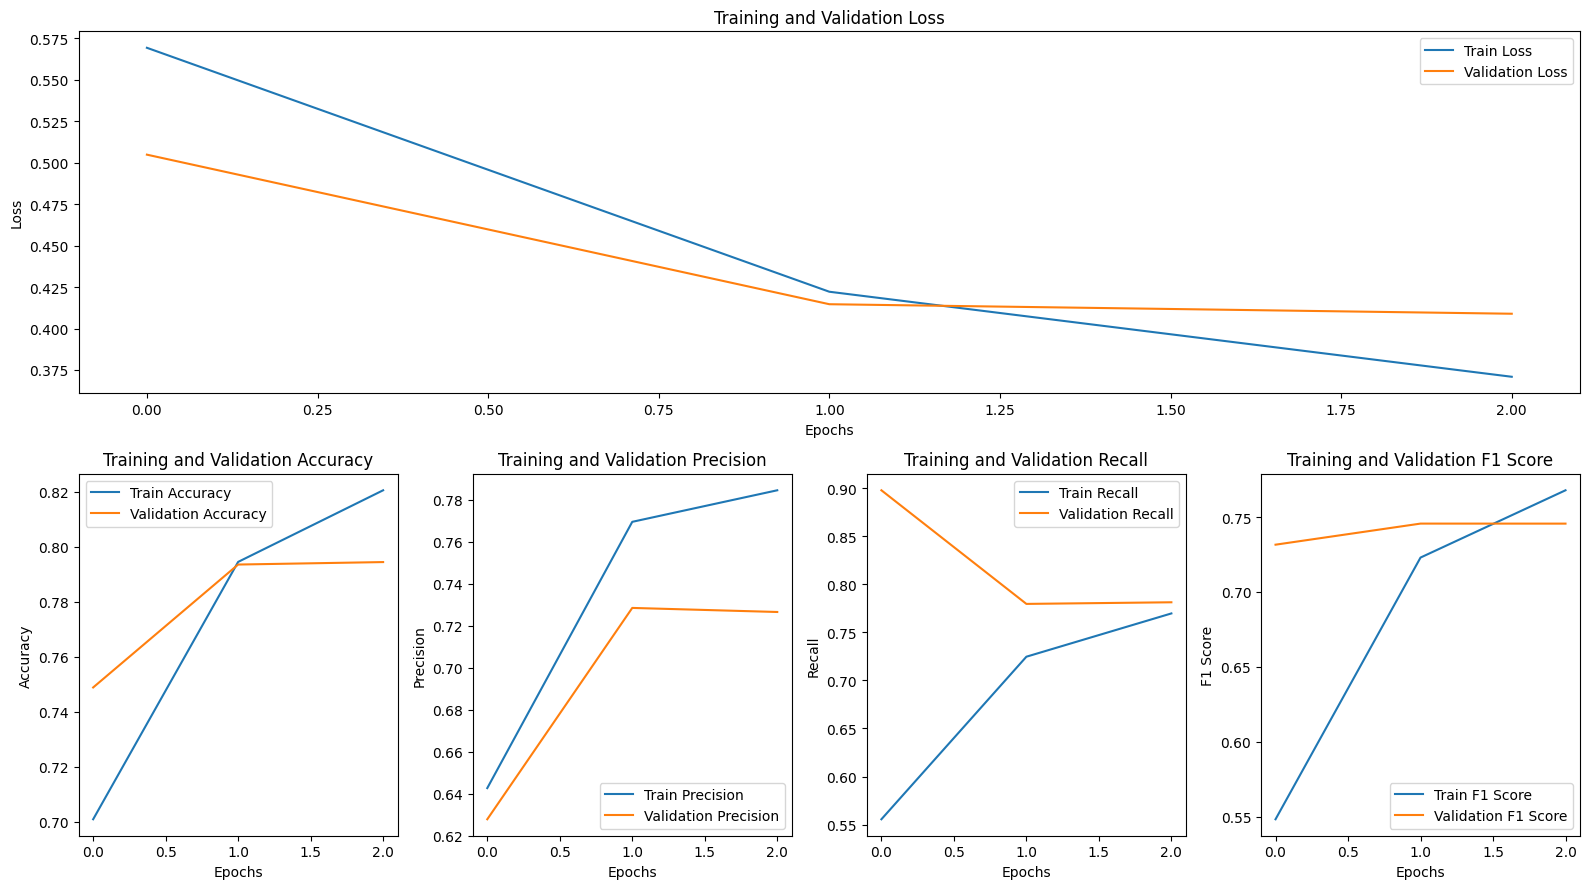

In [65]:
plot_training_history(train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history, valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history)

### 7. 평가

In [66]:
# 모델 로드 함수 정의
def load_model(model_path, text_config):
    model = TransformerModel(text_config)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    return model

# Inference 함수 정의
def inference(model, test_dataloader, device):
    model.eval()

    preds_list = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc='Testing'):
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)

            preds_list.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return preds_list, true_labels

In [67]:
# 저장된 모델 경로
best_model_path = path+'/YouTube(mixed)_Transformers_ACC_0.7945.pth'

In [68]:
# 모델 불러오기
model = load_model(best_model_path, text_config)

In [69]:
preds_list, true_labels = inference(model, test_dataloader, device)

Testing: 100%|██████████| 65/65 [00:12<00:00,  5.23it/s]


In [70]:
# 평가 지표 계산
test_accuracy = accuracy_score(true_labels, preds_list)
test_precision = precision_score(true_labels, preds_list)
test_recall = recall_score(true_labels, preds_list)
test_f1 = f1_score(true_labels, preds_list)
test_cm = confusion_matrix(true_labels, preds_list)

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')
print(f'Test Confusion Matrix: \n{test_cm}')

Test Accuracy: 0.8216
Test Precision: 0.7636
Test Recall: 0.8007
Test F1 Score: 0.7817
Test Confusion Matrix: 
[[1036  204]
 [ 164  659]]
